In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.metrics import accuracy_score
import pandas as pd
from PIL import Image


In [ ]:
# Update with the correct paths for your dataset
dataset_folder = '/content/drive/MyDrive/Dataset/Balanced_Augmented_Data'
train_csv_path = os.path.join(dataset_folder, '/content/drive/MyDrive/Dataset/Balanced_Augmented_Data/primary_train.csv')
val_csv_path = os.path.join(dataset_folder, '/content/drive/MyDrive/Dataset/Balanced_Augmented_Data/primary_valid.csv')
test_csv_path = os.path.join(dataset_folder, '/content/drive/MyDrive/Dataset/Balanced_Augmented_Data/primary_test.csv')
image_folder = os.path.join(dataset_folder, 'images')

In [ ]:
# Define a custom dataset class for the dataset with the new structure
class CustomDatasetFromCSV(Dataset):
    def __init__(self, csv_path, image_folder, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = int(self.data.iloc[idx, 1])  # Assuming the label column is at index 1
        return image, label

In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# Define the ResNet-50 model with pretrained=False and He weight initialization
def initialize_weights(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)

class CustomResNet50(nn.Module):
    def __init__(self, num_classes=9):
        super(CustomResNet50, self).__init__()
        self.model = models.resnet50(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.apply(initialize_weights)

    def forward(self, x):
        return self.model(x)

# Instantiate the custom ResNet-50 model
model = CustomResNet50(num_classes=9)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Create datasets using the new structure
train_dataset = CustomDatasetFromCSV(train_csv_path, image_folder, transform=transform)
val_dataset = CustomDatasetFromCSV(val_csv_path, image_folder, transform=transform)
test_dataset = CustomDatasetFromCSV(test_csv_path, image_folder, transform=transform)

In [ ]:
batch_size=32
# Split the datasets and create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Step 3: Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomResNet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [ ]:
# Initialize variables to keep track of the best model
best_validation_loss = float('inf')
best_model_path = '/content/drive/MyDrive/Dataset/Balanced_Augmented_Data/best_model_3.pth'

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    predictions = []
    true_labels = []

    for images, labels in train_loader:  # Assuming you have defined train_loader
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the gradient buffers
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Loss computation
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    # Compute training accuracy and loss
    training_accuracy = accuracy_score(true_labels, predictions)
    training_loss = total_loss / len(train_loader)  # Compute the average loss

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_total_loss = 0.0
    val_predictions = []
    val_true_labels = []

    for images, labels in val_loader:  # Assuming you have defined val_loader
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_predictions.extend(predicted.cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())

    # Compute validation accuracy and loss
    validation_accuracy = accuracy_score(val_true_labels, val_predictions)
    validation_loss = val_total_loss / len(val_loader)  # Compute the average loss

    # Save the model with the best validation loss
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(model.state_dict(), best_model_path)

    # Print the metrics for this epoch
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy:.4f}")
    print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'my_resnet50_model_3.pth')

# Save the best model based on validation loss
if os.path.exists(best_model_path):
    os.remove(best_model_path)  # Remove previous best model
torch.save(model.state_dict(), best_model_path)
print(f"Best model saved at: {best_model_path}")


Epoch 1/100:
Training Loss: 0.2044, Training Accuracy: 0.9529
Validation Loss: 0.3353, Validation Accuracy: 0.8590
Epoch 2/100:
Training Loss: 0.1757, Training Accuracy: 0.9461
Validation Loss: 0.1790, Validation Accuracy: 0.9383
Epoch 3/100:
Training Loss: 0.1201, Training Accuracy: 0.9626
Validation Loss: 0.0535, Validation Accuracy: 0.9868
Epoch 4/100:
Training Loss: 0.0649, Training Accuracy: 0.9785
Validation Loss: 0.1004, Validation Accuracy: 0.9515
Epoch 5/100:
Training Loss: 0.1195, Training Accuracy: 0.9705
Validation Loss: 0.1824, Validation Accuracy: 0.9295
Epoch 6/100:
Training Loss: 0.1472, Training Accuracy: 0.9518
Validation Loss: 0.1721, Validation Accuracy: 0.9383
Epoch 7/100:
Training Loss: 0.1104, Training Accuracy: 0.9768
Validation Loss: 0.3666, Validation Accuracy: 0.8811
Epoch 8/100:
Training Loss: 0.3280, Training Accuracy: 0.9002
Validation Loss: 0.1367, Validation Accuracy: 0.9648
Epoch 9/100:
Training Loss: 0.1114, Training Accuracy: 0.9683
Validation Loss: 0

In [ ]:
import pandas as pd
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# CustomResNet50 model definition and initialization (include the CustomResNet50 class definition here)

# Load the test data
test_csv_file = '/content/drive/MyDrive/Dataset/Balanced_Augmented_Data/test/output.csv'
test_data = pd.read_csv(test_csv_file)

# Custom dataset class for test data
class TestDataset(Dataset):
    def __init__(self, data, image_dir, transform=None):
        self.data = data
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image

# Define transforms for test data (similar to training)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a dataset and data loader for test data
test_image_dir = '/content/drive/MyDrive/Dataset/Balanced_Augmented_Data/test/classification_dataset'
test_dataset = TestDataset(test_data, test_image_dir, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# Load the trained model (CustomResNet50)
model = CustomResNet50(num_classes=9)  # Use the custom model
model.load_state_dict(torch.load('/content/drive/MyDrive/Dataset/Balanced_Augmented_Data/best_model_3.pth'))

model.eval()  # Set the model to evaluation mode

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Testing loop
predictions = []

with torch.no_grad():
    for images in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Print the predictions
print("Predictions:", predictions)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Predictions: [5, 3, 7, 5, 2, 8, 4, 2, 8, 5, 3, 3, 4, 5, 1, 3, 4, 5, 5, 5, 4, 3, 4, 2, 7, 3, 3, 3, 5, 7, 2, 4, 3, 3, 4, 2, 8, 5, 3, 1, 0, 7, 8, 5, 2, 0, 4, 0, 5, 7, 7, 2, 5, 0, 5, 3, 5, 7, 7, 7, 2, 0, 5, 0, 5, 5, 3, 4, 3, 3, 8, 2, 7, 5, 2, 2, 7, 5, 4, 3, 2, 5, 8, 3, 0, 0, 3, 5, 3, 2, 8, 0, 4, 3, 0, 2, 7, 7, 0, 2, 5, 4, 6, 4, 7, 8, 5, 1, 4, 7, 2, 0, 5, 4, 4, 7, 4, 3, 2, 0, 5, 7, 5, 5, 0, 5, 8, 3, 3, 5, 3, 6, 1, 7, 5, 0, 0, 1, 3, 4, 8, 7, 2, 7, 2, 8, 0, 8, 5, 5, 3, 8, 5, 2, 2, 5, 3, 4, 5, 7, 2, 4, 7, 0, 2, 2, 5, 0, 7, 5, 7, 7, 5, 5, 8, 1, 7, 4, 8, 7, 5, 2, 0, 7, 0, 5, 5, 5, 7, 4]


In [ ]:
from sklearn.metrics import accuracy_score

# Assuming ground truth labels for the test data are in test_data['label']
# Replace 'test_data['label']' with the actual ground truth labels from your test data

# Calculate accuracy
ground_truth_labels = test_data['label'].tolist()  # Ground truth labels
accuracy = accuracy_score(ground_truth_labels, predictions)

# Print the accuracy
print("Accuracy:", accuracy * 100, "%")


Accuracy: 46.31578947368421 %


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming ground truth labels for the test data are in test_data['label']
# Replace 'test_data['label']' with the actual ground truth labels from your test data

# Calculate accuracy
ground_truth_labels = test_data['label'].tolist()  # Ground truth labels
accuracy = accuracy_score(ground_truth_labels, predictions)

# Calculate class-wise accuracy using a confusion matrix
confusion = confusion_matrix(ground_truth_labels, predictions)
class_accuracy = confusion.diagonal() / confusion.sum(axis=1)

# Print the overall accuracy
print("Overall Accuracy:", accuracy * 100, "%")

# Print class-wise accuracy
for i, acc in enumerate(class_accuracy):
    print(f"Class {i}: {acc * 100:.2f}%")

# Print a detailed classification report
report = classification_report(ground_truth_labels, predictions, target_names=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6", "Class 7", "Class 8"])
print(report)


Overall Accuracy: 46.31578947368421 %
Class 0: 71.43%
Class 1: 14.29%
Class 2: 84.21%
Class 3: 20.59%
Class 4: 64.71%
Class 5: 37.50%
Class 6: 100.00%
Class 7: 68.42%
Class 8: nan%
              precision    recall  f1-score   support

     Class 0       0.48      0.71      0.57        14
     Class 1       0.83      0.14      0.24        35
     Class 2       0.64      0.84      0.73        19
     Class 3       0.26      0.21      0.23        34
     Class 4       0.50      0.65      0.56        17
     Class 5       0.28      0.38      0.32        32
     Class 6       0.50      1.00      0.67         1
     Class 7       0.90      0.68      0.78        38
     Class 8       0.00      0.00      0.00         0

    accuracy                           0.46       190
   macro avg       0.49      0.51      0.46       190
weighted avg       0.57      0.46      0.46       190



<ipython-input-21-64f277a80938>:12: RuntimeWarning: invalid value encountered in divide
  class_accuracy = confusion.diagonal() / confusion.sum(axis=1)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this b

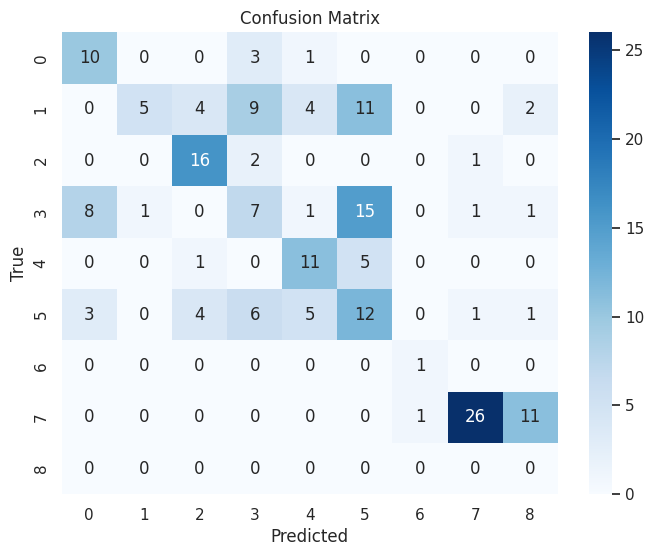

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Ground truth labels for the test data (modify this based on your actual ground truth labels)
# Assuming ground_truth_labels is a list/array of actual labels corresponding to the test data
predictions = [5, 3, 7, 5, 2, 8, 4, 2, 8, 5, 3, 3, 4, 5, 1, 3, 4, 5, 5, 5, 4, 3, 4, 2, 7, 3, 3, 3, 5, 7, 2, 4, 3, 3, 4, 2, 8, 5, 3, 1, 0, 7, 8, 5, 2, 0, 4, 0, 5, 7, 7, 2, 5, 0, 5, 3, 5, 7, 7, 7, 2, 0, 5, 0, 5, 5, 3, 4, 3, 3, 8, 2, 7, 5, 2, 2, 7, 5, 4, 3, 2, 5, 8, 3, 0, 0, 3, 5, 3, 2, 8, 0, 4, 3, 0, 2, 7, 7, 0, 2, 5, 4, 6, 4, 7, 8, 5, 1, 4, 7, 2, 0, 5, 4, 4, 7, 4, 3, 2, 0, 5, 7, 5, 5, 0, 5, 8, 3, 3, 5, 3, 6, 1, 7, 5, 0, 0, 1, 3, 4, 8, 7, 2, 7, 2, 8, 0, 8, 5, 5, 3, 8, 5, 2, 2, 5, 3, 4, 5, 7, 2, 4, 7, 0, 2, 2, 5, 0, 7, 5, 7, 7, 5, 5, 8, 1, 7, 4, 8, 7, 5, 2, 0, 7, 0, 5, 5, 5, 7, 4]

ground_truth_labels = [4, 1, 2, 3, 2, 7, 1, 1, 1, 5, 1, 3, 4, 5, 3, 0, 4, 5, 1, 3, 4, 3, 1, 4, 7, 5, 1, 1, 1, 7, 2, 5, 5, 5, 5, 2, 5, 5, 3, 1, 0, 7, 7, 3, 2, 3, 4, 3, 5, 7, 7, 2, 1, 3, 1, 0, 3, 7, 7, 7, 2, 0, 3, 3, 4, 1, 5, 4, 2, 3, 7, 5, 7, 3, 2, 2, 7, 4, 4, 3, 2, 5, 3, 1, 5, 0, 5, 3, 1, 2, 7, 0, 5, 2, 0, 2, 7, 5, 0, 1, 3, 1, 7, 5, 7, 1, 1, 1, 4, 7, 2, 3, 3, 4, 4, 7, 4, 0, 2, 3, 1, 7, 1, 4, 0, 5, 7, 1, 3, 5, 1, 6, 1, 7, 5, 5, 5, 1, 3, 1, 7, 7, 2, 7, 5, 7, 3, 7, 3, 5, 5, 7, 1, 1, 1, 5, 1, 3, 3, 7, 5, 0, 7, 0, 2, 5, 1, 0, 7, 3, 3, 7, 3, 4, 7, 1, 7, 4, 7, 7, 3, 2, 3, 7, 0, 5, 1, 3, 7, 5]
# Calculate the confusion matrix
cm = confusion_matrix(ground_truth_labels, predictions)

# Get class labels
class_labels = unique_labels(ground_truth_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.set()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
